# Importación de librerías

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Librerías de métricas
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Librerías de modelos
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline

# Librerías de búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import KFold


# Importación de datos

In [77]:
disp_df = pd.read_csv("datos/disp_st2ns1.txt.bz2",
    compression="bz2",
    index_col=0)

# Analisis Exploratorio de Datos

Comprobamos la cantidad de datos que tenemos en el dataset

In [78]:
disp_df_eda = disp_df.copy()

print('Cantidad de Filas y columnas:', disp_df_eda.shape)
print('Nombre columnas:', disp_df_eda.columns)

Cantidad de Filas y columnas: (4380, 76)
Nombre columnas: Index(['apcp_sf1_1', 'apcp_sf2_1', 'apcp_sf3_1', 'apcp_sf4_1', 'apcp_sf5_1',
       'dlwrf_s1_1', 'dlwrf_s2_1', 'dlwrf_s3_1', 'dlwrf_s4_1', 'dlwrf_s5_1',
       'dswrf_s1_1', 'dswrf_s2_1', 'dswrf_s3_1', 'dswrf_s4_1', 'dswrf_s5_1',
       'pres_ms1_1', 'pres_ms2_1', 'pres_ms3_1', 'pres_ms4_1', 'pres_ms5_1',
       'pwat_ea1_1', 'pwat_ea2_1', 'pwat_ea3_1', 'pwat_ea4_1', 'pwat_ea5_1',
       'spfh_2m1_1', 'spfh_2m2_1', 'spfh_2m3_1', 'spfh_2m4_1', 'spfh_2m5_1',
       'tcdc_ea1_1', 'tcdc_ea2_1', 'tcdc_ea3_1', 'tcdc_ea4_1', 'tcdc_ea5_1',
       'tcolc_e1_1', 'tcolc_e2_1', 'tcolc_e3_1', 'tcolc_e4_1', 'tcolc_e5_1',
       'tmax_2m1_1', 'tmax_2m2_1', 'tmax_2m3_1', 'tmax_2m4_1', 'tmax_2m5_1',
       'tmin_2m1_1', 'tmin_2m2_1', 'tmin_2m3_1', 'tmin_2m4_1', 'tmin_2m5_1',
       'tmp_2m_1_1', 'tmp_2m_2_1', 'tmp_2m_3_1', 'tmp_2m_4_1', 'tmp_2m_5_1',
       'tmp_sfc1_1', 'tmp_sfc2_1', 'tmp_sfc3_1', 'tmp_sfc4_1', 'tmp_sfc5_1',
       'ulwrf_s1_1

In [79]:
disp_df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4380 entries, V1 to V4380
Data columns (total 76 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   apcp_sf1_1  4380 non-null   float64
 1   apcp_sf2_1  4380 non-null   float64
 2   apcp_sf3_1  4380 non-null   float64
 3   apcp_sf4_1  4380 non-null   float64
 4   apcp_sf5_1  4380 non-null   float64
 5   dlwrf_s1_1  4380 non-null   float64
 6   dlwrf_s2_1  4380 non-null   float64
 7   dlwrf_s3_1  4380 non-null   float64
 8   dlwrf_s4_1  4380 non-null   float64
 9   dlwrf_s5_1  4380 non-null   float64
 10  dswrf_s1_1  4380 non-null   float64
 11  dswrf_s2_1  4380 non-null   float64
 12  dswrf_s3_1  4380 non-null   float64
 13  dswrf_s4_1  4380 non-null   float64
 14  dswrf_s5_1  4380 non-null   float64
 15  pres_ms1_1  4380 non-null   float64
 16  pres_ms2_1  4380 non-null   float64
 17  pres_ms3_1  4380 non-null   float64
 18  pres_ms4_1  4380 non-null   float64
 19  pres_ms5_1  4380 non-null   fl

In [80]:
disp_df_eda.describe()

,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,...,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1,salida
count,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,...,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4.380000e+03
mean,0.606809,0.252764,0.480446,0.271476,0.514641,316.698532,317.381851,324.682998,343.757513,343.097254,...,247.300145,251.597699,261.916025,260.870143,0.076235,38.585222,76.064674,126.504047,99.087049,1.629826e+07
std,2.275740,0.999809,1.774720,1.086599,1.886735,55.637609,57.874376,58.702133,60.860672,60.693451,...,36.804219,36.382653,39.190955,38.734023,0.255491,25.984861,30.784078,40.571154,35.454368,7.965298e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,158.971770,160.032903,165.524543,183.671312,186.342961,...,113.559602,118.679132,119.393449,121.951425,0.000000,0.000000,3.181818,4.363636,2.545455,5.100000e+05
25%,0.000000,0.000000,0.000000,0.000000,0.000000,271.219564,268.889864,275.709318,293.757163,292.834810,...,230.482578,233.976283,245.721419,243.850282,0.000000,14.000000,53.431818,108.454545,74.795455,1.062375e+07
50%,0.000000,0.000000,0.000000,0.000000,0.000000,321.106932,323.063311,329.708327,346.763388,345.883918,...,253.309217,257.270334,270.790095,269.300432,0.000000,35.363636,79.272727,135.909091,104.818182,1.635690e+07
75%,0.109091,0.051818,0.127500,0.036364,0.090909,366.145476,370.147353,378.509126,399.600853,398.728281,...,274.861445,278.800420,290.139446,289.699652,0.000000,61.818182,102.727273,155.204545,129.545455,2.312775e+07
max,43.009090,16.846364,28.399091,26.381818,36.875455,426.173970,427.486894,429.693146,455.566337,453.910406,...,311.991660,315.569164,328.920274,327.253141,1.000000,92.272727,192.636364,450.636364,313.909091,3.122700e+07


Detección de valores atípicos

<Axes: >

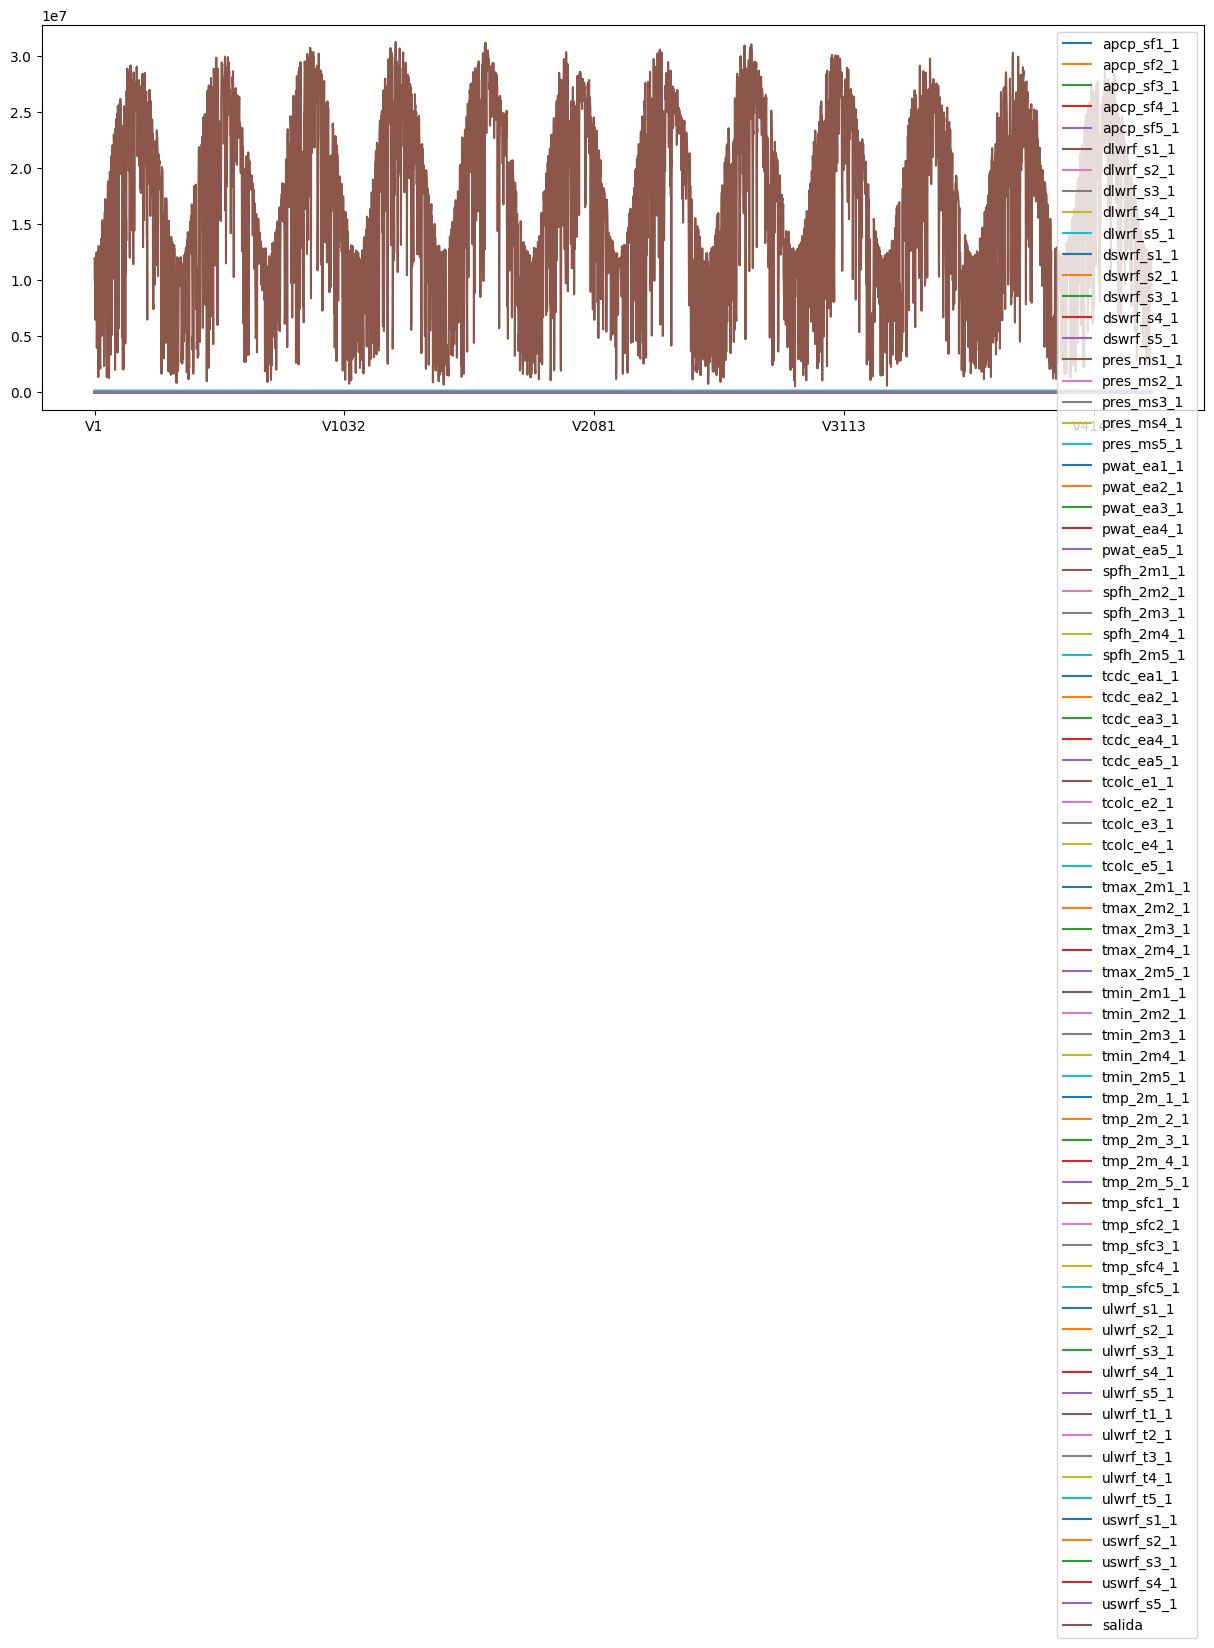

In [81]:
disp_df_wo_outliers = disp_df.copy()
# for col in disp_df_wo_outliers:
#     if col == "salida":
#         print(col)
#         disp_df_wo_outliers.drop(columns=col, inplace=True)
        
disp_df_std = disp_df_wo_outliers.std()
disp_df_mean = disp_df_wo_outliers.mean()
anomaly_cut_off = disp_df_std * 2
lower_limit  = disp_df_mean - anomaly_cut_off
upper_limit = disp_df_mean + anomaly_cut_off

for index, row in disp_df_wo_outliers.iterrows():
    if row.iloc[0] < lower_limit.iloc[0] or row.iloc[0] > upper_limit.iloc[0]:
        disp_df_wo_outliers.drop(index, inplace=True)

disp_df_wo_outliers.plot(kind='line', figsize=(15, 5))


Tomamos una muestra de las 15 variables en el primer momento del día siguiente para ver como se distribuyen los datos

In [82]:
for field in disp_df_eda:
    if field[-3] != "i" and int(field[-3]) != 1:
        disp_df_eda.drop(field, axis=1, inplace=True)

Correlación entre variables

<Axes: >

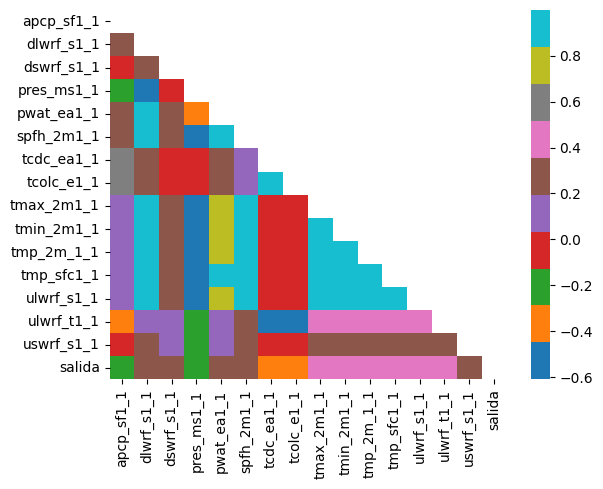

In [83]:
corr = disp_df_eda.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) 
sns.heatmap(lower_tri, xticklabels=corr.columns, yticklabels=corr.columns, cmap= "tab10")

Podemos observar que las variables que mayor correlacción positiva presentan son aquellas correspondientes a la temperatura (tmax_2m1,...,tmp_sfc1) con la variable de ulwrf_t1.
corr negativa (pres_ms1 -> dlwrf_s1); (spfh_2m1 -> pres_ms1); (tmax_2m1-ulwrf_s1 -> pres_ms1); (ulwrf_t1 -> tcdc_ea1-tcolc_e1)

7 ['tcolc_e1_1', 'tcolc_e2_1', 'tcolc_e3_1', 'tcolc_e4_1', 'tcolc_e5_1', 'tmax_2m5_1', 'tmin_2m3_1']


<Axes: >

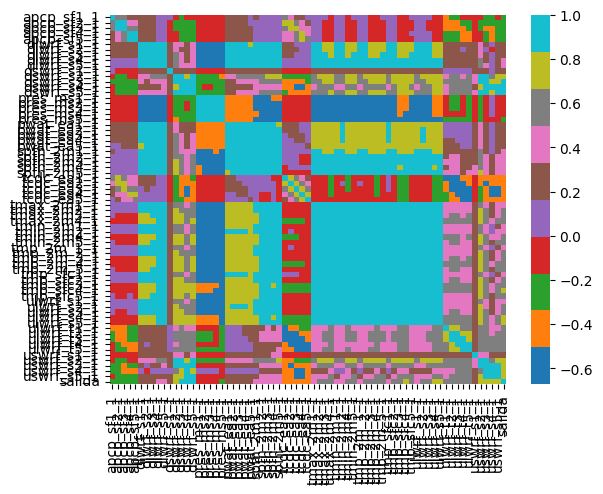

In [84]:
disp_df_corr = disp_df.copy()
corr = disp_df_corr.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) 
to_drop = []

for field in lower_tri:
    for index, row in lower_tri.iterrows():
        if row[field] > 0.9995 or row[field] < -0.9995:
            if index not in to_drop:
                to_drop.append(index)
                disp_df_corr.drop(index, axis=1, inplace=True)
print(len(to_drop),to_drop)

sns.heatmap(disp_df_corr.corr(), xticklabels=disp_df_corr.columns, yticklabels=disp_df_corr.columns, cmap= "tab10")



# Preparación de datos
## Train, test y validación

Dividimos los datos en los conjuntos de train y test. A su vez dividimos el conjunto de train para preparar las comparaciones entre los diferentes modelos.

In [85]:
X_disp = disp_df.iloc[:, :75]
Y_disp = disp_df.iloc[:, 75]

train = disp_df.iloc[:10*365]
test = disp_df.iloc[10*365:]

X_train = train.iloc[:, :75]
Y_train = train.iloc[:, 75]

X_test = test.iloc[:, :75]
Y_test = test.iloc[:, 75]

train_train = train.iloc[:8*365]
train_validation = train.iloc[8*365:]

#separamos la variable objetivo en los sets de entrenamiento y validación
X_train_train = train_train.iloc[:, :75]
Y_train_train = train_train.iloc[:, 75]
X_train_validation = train_validation.iloc[:, :75]
Y_train_validation = train_validation.iloc[:, 75]


## Creación de un modelo dummy

In [86]:
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train_train, Y_train_train)
dummy_pred = dummy.predict(X_train_validation)

dummy_mae = mean_absolute_error(Y_train_validation, dummy_pred)
print("dummy MAE: ",dummy_mae)

dummy_rmse = np.sqrt(mean_squared_error(Y_train_validation,dummy_pred))
print("dummy RMSE: ", dummy_rmse)

dummy MAE:  6720947.2602739725
dummy RMSE:  7809144.902737563


# Métodos Básicos
## Creación de modelos
### KNeighborsRegressor 

In [87]:
start = time.time()

KNN_reg = KNeighborsRegressor()

scaler_x = StandardScaler()
X_train_train_norm = scaler_x.fit_transform(X_train_train)
X_train_validation_norm = scaler_x.transform(X_train_validation)

scaler_y = StandardScaler()
Y_train_train_norm = scaler_y.fit_transform(Y_train_train.values.reshape(-1, 1)).ravel()
Y_train_validation_norm = scaler_y.transform(Y_train_validation.values.reshape(-1, 1)).ravel()

KNN_reg.fit(X_train_train_norm, Y_train_train_norm)
KNN_reg_pred_norm = KNN_reg.predict(X_train_validation_norm)
KNN_reg_pred = scaler_y.inverse_transform(KNN_reg_pred_norm.reshape(-1, 1)).ravel()

end = time.time()

# Métricas
KNN_reg_mae = mean_absolute_error(Y_train_validation, KNN_reg_pred)
print("MAE: ", KNN_reg_mae)

KNN_reg_rmse = np.sqrt(mean_squared_error(Y_train_validation, KNN_reg_pred))
print("RMSE: ", KNN_reg_rmse)


print("Puntuación: ", KNN_reg.score(X_train_validation_norm, Y_train_validation_norm))
print("Tiempo de ejecución: ", end - start)

MAE:  2536714.7671232875
RMSE:  3675153.3534838464
Puntuación:  0.777642376391267
Tiempo de ejecución:  0.03341245651245117


### Árbol de regresión

In [88]:
start = time.time()

tree_reg = DecisionTreeRegressor(random_state=2)
tree_reg.fit(X_train_train, Y_train_train)
tree_reg_pred = tree_reg.predict(X_train_validation)

end = time.time()

tree_reg_mae = mean_absolute_error(Y_train_validation, tree_reg_pred)
print("MAE: ", tree_reg_mae)

tree_reg_rmse = np.sqrt(mean_squared_error(Y_train_validation, tree_reg_pred))
print("RMSE: ", tree_reg_rmse)

print("Puntuación: ", tree_reg.score(X_train_validation, Y_train_validation))
print("Tiempo de ejecución: ", end - start)


MAE:  3344148.493150685
RMSE:  4829894.676721137
Puntuación:  0.6159600420419615
Tiempo de ejecución:  0.2743661403656006


### Regresión lineal

In [89]:
start = time.time()

li_reg = LinearRegression()
li_reg.fit(X_train_train, Y_train_train)
li_reg_pred = li_reg.predict(X_train_validation)

end = time.time()

li_reg_mae = mean_absolute_error(Y_train_validation, li_reg_pred)
print("MAE: ", li_reg_mae)

li_reg_rmse = np.sqrt(mean_squared_error(Y_train_validation, li_reg_pred))
print("RMSE: ", li_reg_rmse)

print("Puntuación: ", li_reg.score(X_train_validation, Y_train_validation))
print("Tiempo de ejecución: ", end - start)


MAE:  2265683.8029644764
RMSE:  3268115.476041282
Puntuación:  0.8241688243985801
Tiempo de ejecución:  0.032648563385009766


## Ajuste de hiperparámetros por búsqueda en cuadrícula

### KNeighborsRegressor

In [90]:
start = time.time()

param_grid = {
    'n_neighbors': np.arange(1, 20), 
    'weights': ['uniform', 'distance'], 
    'p': [1, 2, 3, 4]
    }

# 3-Fold cross validation for the inner loop.
inner = KFold(n_splits=3, shuffle=True, random_state=2)

grid = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'], 
    refit='neg_mean_absolute_error',
    cv=inner,
    verbose=3,
    n_jobs=-1)

grid.fit(X_train_train_norm, Y_train_train_norm)

end = time.time()

knn_best_params = grid.best_params_

print("Tiempo de ejecución: ", end - start)
print("Mejor modelo: ", grid.best_estimator_)


Fitting 3 folds for each of 152 candidates, totalling 456 fits
Tiempo de ejecución:  161.99488306045532
Mejor modelo:  KNeighborsRegressor(n_neighbors=16, p=1, weights='distance')


Evaluación del modelo

In [91]:
# entrenar modelo
mejor_modelo = KNeighborsRegressor(**grid.best_params_)
mejor_modelo.fit(X_train_train_norm, Y_train_train_norm)

y_pred = mejor_modelo.predict(X_train_validation_norm)

# Evaluacion
mejor_modelo_mae = mean_absolute_error(Y_train_validation_norm, y_pred)
print("MAE: ", mejor_modelo_mae)
mejor_modelo_rmse = np.sqrt(mean_squared_error(Y_train_validation_norm, y_pred))
print("RMSE: ", mejor_modelo_rmse)
print("Puntuación: ", mejor_modelo.score(X_train_validation_norm, Y_train_validation_norm))

MAE:  0.29598215420226826
RMSE:  0.430401805219425
Puntuación:  0.7988934106465473


### Árboles de regresión

In [92]:
start = time.time()

param_grid = {
    'max_depth': range(2, 16, 2),
    'min_samples_split': range(2, 16, 2)
}

# 3-Fold cross validation for the inner loop.
inner = KFold(n_splits=3, shuffle=True, random_state=2)

grid = GridSearchCV(estimator=DecisionTreeRegressor(random_state=2),
                    param_grid=param_grid,
                    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'], 
                    refit='neg_mean_absolute_error',
                    cv=inner, 
                    n_jobs=1,
                    verbose=3)

grid.fit(X_train_train, Y_train_train)

end = time.time()

tree_reg_best_params = grid.best_params_


print("Tiempo de ejecución: ", end - start)
print("Mejor modelo: ", grid.best_estimator_)

Fitting 3 folds for each of 49 candidates, totalling 147 fits
[CV 1/3] END max_depth=2, min_samples_split=2; neg_mean_absolute_error: (test=-3193896.506) neg_mean_squared_error: (test=-17365950489320.361) total time=   0.0s
[CV 2/3] END max_depth=2, min_samples_split=2; neg_mean_absolute_error: (test=-3382694.233) neg_mean_squared_error: (test=-20597791350163.125) total time=   0.0s
[CV 3/3] END max_depth=2, min_samples_split=2; neg_mean_absolute_error: (test=-3320330.613) neg_mean_squared_error: (test=-18903534394093.836) total time=   0.0s
[CV 1/3] END max_depth=2, min_samples_split=4; neg_mean_absolute_error: (test=-3193896.506) neg_mean_squared_error: (test=-17365950489320.361) total time=   0.0s
[CV 2/3] END max_depth=2, min_samples_split=4; neg_mean_absolute_error: (test=-3382694.233) neg_mean_squared_error: (test=-20597791350163.125) total time=   0.0s
[CV 3/3] END max_depth=2, min_samples_split=4; neg_mean_absolute_error: (test=-3320330.613) neg_mean_squared_error: (test=-18903

Evaluación del modelo

In [93]:
# entrenar modelo
mejor_modelo = DecisionTreeRegressor(**grid.best_params_)
mejor_modelo.fit(X_train_train, Y_train_train)

y_pred = mejor_modelo.predict(X_train_validation)

# Evaluacion
mejor_modelo_mae = mean_absolute_error(Y_train_validation, y_pred)
print("MAE: ", mejor_modelo_mae)
mejor_modelo_rmse = np.sqrt(mean_squared_error(Y_train_validation, y_pred))
print("RMSE: ", mejor_modelo_rmse)
print("Puntuación: ", mejor_modelo.score(X_train_validation, Y_train_validation))

MAE:  2690546.341587113
RMSE:  3837547.0473016244
Puntuación:  0.7575576313529241


### Regresión lineal

In [94]:
start = time.time()

param_grid ={
    #hiperparametros para regresion lineal
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
    
}

# 3-Fold cross validation for the inner loop.
inner = KFold(n_splits=3, shuffle=True, random_state=2)

grid = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=param_grid,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'], 
    refit='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=3)

grid.fit(X_train_train, Y_train_train)

end = time.time()

li_reg_best_params = grid.best_params_

print("Tiempo de ejecución: ", end - start)
print("Mejor modelo: ", grid.best_estimator_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tiempo de ejecución:  0.9778571128845215
Mejor modelo:  LinearRegression()


Evaluación del modelo

In [95]:
# entrenar modelo
mejor_modelo = LinearRegression(**grid.best_params_)
mejor_modelo.fit(X_train_train, Y_train_train)

y_pred = mejor_modelo.predict(X_train_validation)

# Evaluacion
mejor_modelo_mae = mean_absolute_error(Y_train_validation, y_pred)
print("MAE: ", mejor_modelo_mae)
mejor_modelo_rmse = np.sqrt(mean_squared_error(Y_train_validation, y_pred))
print("RMSE: ", mejor_modelo_rmse)
print("Puntuación: ", mejor_modelo.score(X_train_validation, Y_train_validation))

MAE:  2265683.8029644764
RMSE:  3268115.476041282
Puntuación:  0.8241688243985801


El modelo con mayor score es el de regresión lineal, por lo que procedemos a usarlo para predecir los valores de la variable de test.

# Reducción de dimensionalidad

Procedemos a reducir la dimensionalidad de los datos para ver si se mejora el score del modelo. 

Utilizamos los datos restantes del proceso de correlación

In [96]:
# print(disp_df_corr.shape)
train_co = disp_df_corr.iloc[:10*365]
test_co = disp_df_corr.iloc[10*365:]

train_train_co = train_co.iloc[:8*365]
train_validation_co = train_co.iloc[8*365:]

#separamos la variable objetivo en los sets de entrenamiento y validación
X_train_train_co = train_train_co.iloc[:, :68]
Y_train_train_co = train_train_co.iloc[:, 68]

X_train_validation_co = train_validation_co.iloc[:, :68]
Y_train_validation_co = train_validation_co.iloc[:, 68]

Usamos el modelo de regresión lineal para predecir los valores de la variable de test.

In [97]:
li_reg = LinearRegression()
li_reg.fit(X_train_train_co, Y_train_train_co)
li_reg_pred = li_reg.predict(X_train_validation_co)

li_reg_mae = mean_absolute_error(Y_train_validation_co, li_reg_pred)
print("MAE: ", li_reg_mae)

li_reg_rmse = np.sqrt(mean_squared_error(Y_train_validation_co, li_reg_pred))
print("RMSE: ", li_reg_rmse)

print("Puntuación: ", li_reg.score(X_train_validation_co, Y_train_validation_co))

MAE:  2257687.430023777
RMSE:  3264826.850488732
Puntuación:  0.8245225156713238


In [98]:
start = time.time()

param_grid ={
    #hiperparametros para regresion lineal
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
    
}

# 3-Fold cross validation for the inner loop.
inner = KFold(n_splits=3, shuffle=True, random_state=2)

grid = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=param_grid,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'], 
    refit='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=3)

grid.fit(X_train_train_co, Y_train_train_co)

end = time.time()

print("Tiempo de ejecución: ", end - start)
print("Mejor modelo: ", grid.best_estimator_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tiempo de ejecución:  0.30266690254211426
Mejor modelo:  LinearRegression()


In [99]:
# entrenar modelo
mejor_modelo = LinearRegression(**grid.best_params_)
mejor_modelo.fit(X_train_train_co, Y_train_train_co)

y_pred = mejor_modelo.predict(X_train_validation_co)

# Evaluacion
mejor_modelo_mae = mean_absolute_error(Y_train_validation_co, y_pred)
print("MAE: ", mejor_modelo_mae)
mejor_modelo_rmse = np.sqrt(mean_squared_error(Y_train_validation_co, y_pred))
print("RMSE: ", mejor_modelo_rmse)
print("Puntuación: ", mejor_modelo.score(X_train_validation_co, Y_train_validation_co))

MAE:  2257687.430023777
RMSE:  3264826.850488732
Puntuación:  0.8245225156713238


# Métodos Avanzados
## Creación de modelos

### SVM

In [100]:
start = time.time()
svm = SVR()
scaler = StandardScaler()

X_train_train_norm = scaler.fit_transform(X_train_train)
X_train_validation_norm = scaler.transform(X_train_validation)

scaler_y = StandardScaler()
Y_train_train_norm = scaler_y.fit_transform(Y_train_train.values.reshape(-1, 1)).ravel()
Y_train_validation_norm = scaler_y.transform(Y_train_validation.values.reshape(-1, 1)).ravel()

svm.fit(X_train_train_norm, Y_train_train_norm)
y_pred_norm = svm.predict(X_train_validation_norm)
y_pred = scaler_y.inverse_transform(y_pred_norm.reshape(-1, 1)).ravel()

end = time.time()

svm_mae = mean_absolute_error(Y_train_validation, y_pred)
print("MAE: ", svm_mae)

svm_rmse = np.sqrt(mean_squared_error(Y_train_validation, y_pred))
print("RMSE: ", svm_rmse)

print("Puntuación: ", svm.score(X_train_validation_norm, Y_train_validation_norm))
print("Tiempo de ejecución: ", end - start)


MAE:  2224652.794901519
RMSE:  3353514.5586067806
Puntuación:  0.8148594775863227
Tiempo de ejecución:  0.6477205753326416


### Random Forest

In [101]:
start = time.time()

rfr = RandomForestRegressor(random_state=2)
rfr.fit(X_train_train, Y_train_train)
rfr_pred = rfr.predict(X_train_validation)

end = time.time()

rfr_mae = mean_absolute_error(Y_train_validation, rfr_pred)
print("MAE: ", rfr_mae)

rfr_rmse = np.sqrt(mean_squared_error(Y_train_validation, rfr_pred))
print("RMSE: ", rfr_rmse)

print("Puntuación: ", rfr.score(X_train_validation, Y_train_validation))
print("Tiempo de ejecución: ", end - start)


MAE:  2278659.197260274
RMSE:  3341026.470443267
Puntuación:  0.8162357926282553
Tiempo de ejecución:  22.077763319015503


## Ajuste de hiperparámetros por búsqueda en cuadrícula
### SVM

In [102]:
start = time.time()
pipe_svr = Pipeline([('scale', scaler), ('SVM', svm)])

np.random.seed(2)
pipe_svr.fit(X_train_train, Y_train_train)



param_grid ={
    # 'kernel': ['poly', 'rbf', 'sigmoid', 'linear'],
    'SVM__C' : [0.1, 1, 10, 100],
    'SVM__gamma': [0.01, 0.1, 1],    
}

inner = KFold(n_splits=3, shuffle=True, random_state=2)

grid = GridSearchCV(
    # estimator=SVR(),
    pipe_svr,
    param_grid=param_grid,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], 
    refit='neg_mean_absolute_error',
    cv=inner,
    n_jobs=4,
    verbose=1)

np.random.seed(2)
grid.fit(X_train_train_norm, Y_train_train_norm)

end = time.time()

svm_best_params = grid.best_params_

print("Tiempo de ejecución: ", end - start)
print("Mejor modelo: ", grid.best_estimator_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Tiempo de ejecución:  10.305450439453125
Mejor modelo:  Pipeline(steps=[('scale', StandardScaler()), ('SVM', SVR(C=1, gamma=0.01))])


Evaluación del modelo

In [103]:
# entrenar modelo    
mejor_modelo = SVR(
    C= grid.best_params_['SVM__C'],
    gamma= grid.best_params_['SVM__gamma'],
    ) 
mejor_modelo.fit(X_train_train_norm, Y_train_train_norm)

y_pred = mejor_modelo.predict(X_train_validation_norm)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()

# Evaluacion
svm_mae = mean_absolute_error(Y_train_validation, y_pred)
print("MAE: ", svm_mae)

svm_rmse = np.sqrt(mean_squared_error(Y_train_validation, y_pred))
print("RMSE: ", svm_rmse)

print("Puntuación: ", mejor_modelo.score(X_train_validation_norm, Y_train_validation_norm))

MAE:  2207095.8581021917
RMSE:  3341132.405893116
Puntuación:  0.8162241390524618


### Random Forest

In [104]:
start = time.time()

param_grid ={
    'n_estimators': [10, 100 ,1000],
    'max_features': ['sqrt', 'log2', 25]
}

grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=2),
    param_grid=param_grid,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'], 
    refit='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=3)

grid.fit(X_train_train, Y_train_train)

end = time.time()

rfr_best_params = grid.best_params_

print("Tiempo de ejecución: ", end - start)
print("Mejor modelo: ", grid.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Tiempo de ejecución:  137.4615125656128
Mejor modelo:  RandomForestRegressor(max_features='sqrt', n_estimators=1000, random_state=2)


Evaluación del modelo

In [105]:
# entrenar modelo
mejor_modelo = RandomForestRegressor(**grid.best_params_)
mejor_modelo.fit(X_train_train, Y_train_train)

y_pred = mejor_modelo.predict(X_train_validation)

# Evaluacion
mejor_modelo_mae = mean_absolute_error(Y_train_validation, y_pred)
print("MAE: ", mejor_modelo_mae)
mejor_modelo_rmse = np.sqrt(mean_squared_error(Y_train_validation, y_pred))
print("RMSE: ", mejor_modelo_rmse)
print("Puntuación: ", mejor_modelo.score(X_train_validation, Y_train_validation))

MAE:  2195923.9997260277
RMSE:  3224602.9413210703
Puntuación:  0.8288197783955508


# Modelo final

Observando con el GridSearchCV los mejores parámetros para cada modelo, podemos observar que el modelo con mejor score es el de Random Forest. Aun así, volveremos a comprobar todos los modelos con los datos de test.

## Comprobación con test

Normalizamos los datos de test

In [106]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

scaler_y = StandardScaler()
scaler_y.fit(Y_train.values.reshape(-1, 1))
Y_train_norm = scaler_y.transform(Y_train.values.reshape(-1, 1)).ravel()
Y_test_norm = scaler_y.transform(Y_test.values.reshape(-1, 1)).ravel()

### KNeighborsRegressor

In [107]:
knn = KNeighborsRegressor(**knn_best_params)
knn.fit(X_train_norm, Y_train_norm)

knn_pred = knn.predict(X_test_norm)
knn_pred = scaler_y.inverse_transform(knn_pred.reshape(-1, 1)).ravel()

# Evaluacion
knn_mae = mean_absolute_error(Y_test_norm, knn_pred)
print("MAE: ", knn_mae)
knn_rmse = np.sqrt(mean_squared_error(Y_test_norm, knn_pred))
print("RMSE: ", knn_rmse)
print("Puntuación: ", knn.score(X_test_norm, Y_test_norm))

MAE:  16701353.221029537
RMSE:  18112113.662134513
Puntuación:  0.8028655997135089


### Árbol de regresión

In [108]:
tree_reg = DecisionTreeRegressor(**tree_reg_best_params)
tree_reg.fit(X_train, Y_train)

tree_reg_pred = tree_reg.predict(X_test)

# Evaluacion
tree_reg_mae = mean_absolute_error(Y_test, tree_reg_pred)
print("MAE: ", tree_reg_mae)
tree_reg_rmse = np.sqrt(mean_squared_error(Y_test, tree_reg_pred))
print("RMSE: ", tree_reg_rmse)
print("Puntuación: ", tree_reg.score(X_test, Y_test))

MAE:  2581999.1606944404
RMSE:  3689463.356834892
Puntuación:  0.7555105491347747


### Linear Regression

In [109]:
li_reg = LinearRegression()
li_reg.fit(X_train, Y_train)

li_reg_pred = li_reg.predict(X_test)

# Evaluacion
li_reg_mae = mean_absolute_error(Y_test, li_reg_pred)
print("MAE: ", li_reg_mae)
li_reg_rmse = np.sqrt(mean_squared_error(Y_test, li_reg_pred))
print("RMSE: ", li_reg_rmse)
print("Puntuación: ", li_reg.score(X_test, Y_test))


MAE:  2242422.3671045974
RMSE:  3103586.448676004
Puntuación:  0.8269938999643136


### SVM

In [110]:
svm = SVR(
    C= svm_best_params['SVM__C'],
    gamma= svm_best_params['SVM__gamma'],
    ) 

svm.fit(X_train_norm, Y_train_norm)

svm_pred = svm.predict(X_test_norm)
svm_pred = scaler_y.inverse_transform(svm_pred.reshape(-1, 1)).ravel()

# Evaluacion
svm_mae = mean_absolute_error(Y_test, svm_pred)
print("MAE: ", svm_mae)
svm_rmse = np.sqrt(mean_squared_error(Y_test, svm_pred))
print("RMSE: ", svm_rmse)
print("Puntuación: ", svm.score(X_test_norm, Y_test_norm))

MAE:  2205116.4119538656
RMSE:  3209823.6765222913
Puntuación:  0.8149470235652386


### Random Forest

In [111]:
rfr = RandomForestRegressor(**rfr_best_params)
rfr.fit(X_train, Y_train)

rfr_pred = rfr.predict(X_test)

# Evaluacion
rfr_mae = mean_absolute_error(Y_test, rfr_pred)
print("MAE: ", rfr_mae)
rfr_rmse = np.sqrt(mean_squared_error(Y_test, rfr_pred))
print("RMSE: ", rfr_rmse)
print("Puntuación: ", rfr.score(X_test, Y_test))

MAE:  2105769.0780821918
RMSE:  3046262.524309079
Puntuación:  0.8333258005455184


Elegimos el modelo de Random Forest como el modelo final.

## Entrenamiento del modelo final

In [112]:
import pickle

rfr = RandomForestRegressor(**rfr_best_params)
rfr.fit(X_disp, Y_disp)


filename = 'mejor_modelo.pkl'
pickle.dump(mejor_modelo, open(filename, 'wb'))